Running Meteorological Data Example
Meteorological Data Cleaning Summary:
         field  points_removed  percent_removed replacement_method
0  temperature               2         0.138793        interpolate
1     humidity               6         0.416378        interpolate
2   wind_speed              27         1.873699        interpolate


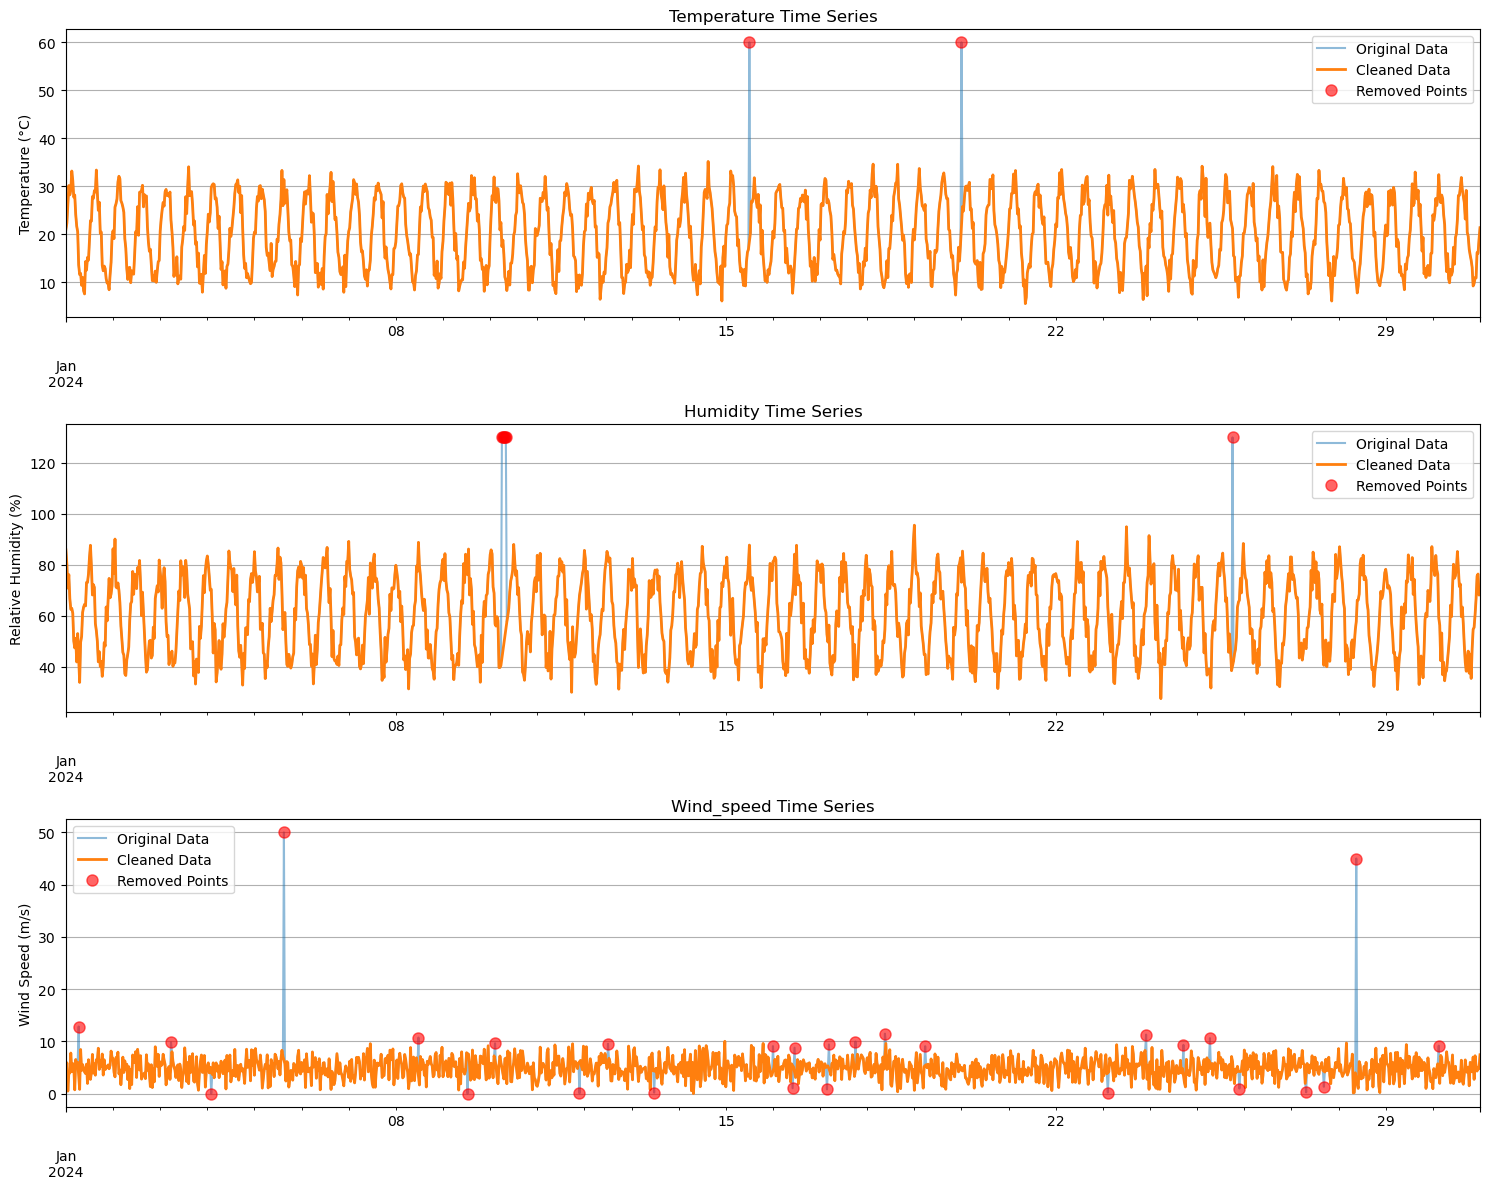

In [12]:
import pandas as pd
import numpy as np
from micromet.outlier_removal import detect_extreme_variations, clean_extreme_variations

def meteorological_example():
    """
    Example of cleaning meteorological data with daily cycles and clear outliers
    """
    # Create sample half hourly data for one month
    dates = pd.date_range(start='2024-01-01', end='2024-01-31', freq='30min')
    
    # Generate realistic meteorological data with daily cycles
    np.random.seed(42)  # For reproducibility
    base_temp = 20 + 10 * np.sin(np.arange(len(dates)) * 2 * np.pi / 24)
    base_humid = 60 + 20 * np.cos(np.arange(len(dates)) * 2 * np.pi / 24)
    
    data = pd.DataFrame({
        'temperature': base_temp + np.random.normal(0, 2, len(dates)),
        'humidity': base_humid + np.random.normal(0, 5, len(dates)),
        'wind_speed': np.abs(np.random.normal(5, 2, len(dates)))
    }, index=dates)
    
    # Add more extreme outliers
    # Temperature spikes (40 degrees above normal)
    data.loc['2024-01-15 12:00:00', 'temperature'] = base_temp[336] + 40
    data.loc['2024-01-20 00:00:00', 'temperature'] = base_temp[456] + 40
    
    # Impossible humidity values (>100%)
    data.loc['2024-01-10 06:00:00':'2024-01-10 08:00:00', 'humidity'] = 130
    data.loc['2024-01-25 18:00:00', 'humidity'] = 130
    
    # Extreme wind gusts
    data.loc['2024-01-05 15:00:00', 'wind_speed'] = 50
    data.loc['2024-01-28 09:00:00', 'wind_speed'] = 45
    
    # Clean the data with more sensitive thresholds
    results = clean_extreme_variations(
        df=data,
        frequency='D',
        variation_threshold=2.2,  # More sensitive threshold
        replacement_method='interpolate'
    )
    
    print("Meteorological Data Cleaning Summary:")
    print(results['cleaning_summary'])
    
    # Plot the results with error checking
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    for i, col in enumerate(['temperature', 'humidity', 'wind_speed']):
        # Plot original data
        data[col].plot(ax=axes[i], label='Original Data', alpha=0.5)
        results['cleaned_data'][col].plot(ax=axes[i], label='Cleaned Data', linewidth=2)
        
        # Plot removed points if they exist
        removed_points = results['removed_points'][col].dropna()
        if not removed_points.empty:
            removed_points.plot(ax=axes[i], style='ro', label='Removed Points', 
                              markersize=8, alpha=0.6)
        
        axes[i].set_title(f'{col.capitalize()} Time Series')
        axes[i].legend()
        axes[i].grid(True)
        
        # Add y-axis labels
        if col == 'temperature':
            axes[i].set_ylabel('Temperature (°C)')
        elif col == 'humidity':
            axes[i].set_ylabel('Relative Humidity (%)')
        else:
            axes[i].set_ylabel('Wind Speed (m/s)')
    
    plt.tight_layout()
    return results, fig

# Example usage
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    
    print("Running Meteorological Data Example")
    results, fig = meteorological_example()
    plt.show()